<a href="https://colab.research.google.com/github/serdarbozoglan/01_Computer_Vision/blob/master/PyTorch06_MNIST_NN_Good_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision
import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

     |████████████████████████████████| 2.1MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
# First we convert images to Tensors
# Then we normalize the values between [-1, 1]
# first (0.5, 0.5, 0.5) mean of channel, height, width and second ones are std dev for each one 
# Normalize ederken sadece (0.5), (0.5) uygalamaizin nedeni gray scale oldugu icin
# Eger 3 color olsydi (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) uygulayacaktik
transform = T.Compose([T.Resize((28,28)),
                       T.ToTensor(),
                       T.Normalize((0.5), (0.5))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# For Validation set, train=FALSE
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = DataLoader(training_dataset, batch_size=100, shuffle=True)

# No Need to Shuffle Validation Data
validation_loader = DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [0]:
# numpy array a cevirecegiz simdi de
# dimension [channels, height, width]
# PLOTLAMAK ICIN [HEIGHT WIDTH CHANNELS] formatinda olmali
# [1, 28, 28] olan format [28, 28, 1] formatinda olmali
def image_convert(tensor):
    image = tensor.clone().detach().numpy()

    # [28, 28, 1] shape icin:
    # Bastaki channel sona gidecek, digerleri 1 sola kayacak 
    image = image.transpose(1, 2, 0)
    
    print(image.shape)

    # image i DE-normalize haline getirmek icin
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))

    # setting the values between [0, 1]
    image = image.clip(0,1)

    return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


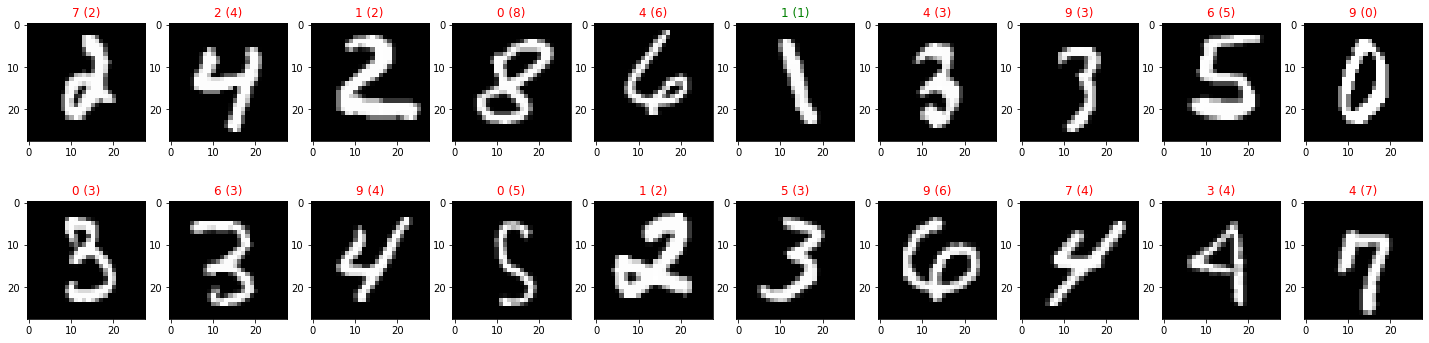

In [162]:
data_iter = iter(training_loader);

# data_iter.next() --> bring us a BATCH of data each time
images, labels = data_iter.next();

fig = plt.figure(figsize=(25, 6));

# We ll check 20 images from training set
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1);
    plt.imshow(image_convert(images[idx]));
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=('green' if preds[idx]==labels[idx] else 'red'));
plt.show();

In [0]:
class Classifier(nn.Module):
    # D_in --> input nodes
    # H1 --> number of Nodes in Hidden Layer 1, H2 --> Nodes in Hidden Layer 2 
    # D_out output noes
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        # output layer'da raw score elde etemk icin herhangi bir activation function kullanmiyoruz
        # CrossEntropy Loss functioni kulanabilmek icin raw score istiyoruz 
        x = self.linear3(x)
        return x

In [6]:
# Modele 28x28 = 784 node olarak girer her bir image, yani her bir pixel bir node olur inputta
# 128 --> 1nci hidden layer'daki node sayisi
# 64 --> 2nci hidden layer'daki node sayisi
# 10 --> Output label sayisi
model = Classifier(784, 128, 64, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [126]:
epochs= 20
running_loss_history = []
running_correct_history =[]
val_running_loss_history = []
val_running_correct_history =[]

for epoch in tqdm(range(epochs)):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for images, labels in training_loader:
        # right now the shape is 1, 28, 28 formatinda, bunu flatten ederek neural network'e sokabiliriz
        # 1, 784'luk duz bir vektore donusturmemiz gerekiyor, color channel' oldugu gibi birakacagiz
        # -1 ile kalanlasi flatten hale getirmis oluyoruz
        inputs = images.view(images.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, dim=1) # satirdaki enbuyuk degeri getirir
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_images, val_labels in validation_loader:
                val_inputs = val_images.view(val_images.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, dim=1) # satirdaki en buyuk degeri getirir
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        # her epoch'un toplam epoch loss'unu buluruz
        # TRAINING SET
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float()/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        print(f'[INFO] {epoch+1}. Epoch Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        # VALIDATION SET
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_acc)
        print(f'[INFO] {epoch+1}. Epoch Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')

  5%|▌         | 1/20 [00:09<02:54,  9.19s/it]

[INFO] 1. Epoch Train Loss: 0.1400, Acc: 95.9183
[INFO] 1. Epoch Val Loss: 0.1392, Acc: 95.8700


 10%|█         | 2/20 [00:18<02:44,  9.16s/it]

[INFO] 2. Epoch Train Loss: 0.1319, Acc: 96.1750
[INFO] 2. Epoch Val Loss: 0.1338, Acc: 95.8800


 15%|█▌        | 3/20 [00:27<02:35,  9.17s/it]

[INFO] 3. Epoch Train Loss: 0.1243, Acc: 96.4133
[INFO] 3. Epoch Val Loss: 0.1276, Acc: 96.1300


 20%|██        | 4/20 [00:36<02:27,  9.20s/it]

[INFO] 4. Epoch Train Loss: 0.1173, Acc: 96.5817
[INFO] 4. Epoch Val Loss: 0.1225, Acc: 96.2200


 25%|██▌       | 5/20 [00:46<02:18,  9.24s/it]

[INFO] 5. Epoch Train Loss: 0.1120, Acc: 96.7033
[INFO] 5. Epoch Val Loss: 0.1163, Acc: 96.4900


 30%|███       | 6/20 [00:55<02:09,  9.22s/it]

[INFO] 6. Epoch Train Loss: 0.1053, Acc: 96.9933
[INFO] 6. Epoch Val Loss: 0.1174, Acc: 96.5400


 35%|███▌      | 7/20 [01:04<01:59,  9.18s/it]

[INFO] 7. Epoch Train Loss: 0.1008, Acc: 97.0600
[INFO] 7. Epoch Val Loss: 0.1094, Acc: 96.6500


 40%|████      | 8/20 [01:13<01:49,  9.15s/it]

[INFO] 8. Epoch Train Loss: 0.0959, Acc: 97.2433
[INFO] 8. Epoch Val Loss: 0.1097, Acc: 96.7300


 45%|████▌     | 9/20 [01:22<01:40,  9.13s/it]

[INFO] 9. Epoch Train Loss: 0.0921, Acc: 97.2867
[INFO] 9. Epoch Val Loss: 0.1045, Acc: 96.8900


 50%|█████     | 10/20 [01:31<01:31,  9.12s/it]

[INFO] 10. Epoch Train Loss: 0.0877, Acc: 97.4167
[INFO] 10. Epoch Val Loss: 0.1031, Acc: 96.9700


 55%|█████▌    | 11/20 [01:40<01:21,  9.09s/it]

[INFO] 11. Epoch Train Loss: 0.0836, Acc: 97.5717
[INFO] 11. Epoch Val Loss: 0.0979, Acc: 97.0000


 60%|██████    | 12/20 [01:49<01:12,  9.07s/it]

[INFO] 12. Epoch Train Loss: 0.0803, Acc: 97.6850
[INFO] 12. Epoch Val Loss: 0.0975, Acc: 96.9000


 65%|██████▌   | 13/20 [01:58<01:03,  9.09s/it]

[INFO] 13. Epoch Train Loss: 0.0777, Acc: 97.7217
[INFO] 13. Epoch Val Loss: 0.0935, Acc: 97.1100


 70%|███████   | 14/20 [02:07<00:54,  9.13s/it]

[INFO] 14. Epoch Train Loss: 0.0741, Acc: 97.8600
[INFO] 14. Epoch Val Loss: 0.0962, Acc: 97.0100


 75%|███████▌  | 15/20 [02:17<00:45,  9.11s/it]

[INFO] 15. Epoch Train Loss: 0.0712, Acc: 97.8867
[INFO] 15. Epoch Val Loss: 0.0923, Acc: 97.2700


 80%|████████  | 16/20 [02:26<00:36,  9.10s/it]

[INFO] 16. Epoch Train Loss: 0.0681, Acc: 98.0183
[INFO] 16. Epoch Val Loss: 0.0915, Acc: 97.2800


 85%|████████▌ | 17/20 [02:35<00:27,  9.09s/it]

[INFO] 17. Epoch Train Loss: 0.0656, Acc: 98.0900
[INFO] 17. Epoch Val Loss: 0.0905, Acc: 97.2800


 90%|█████████ | 18/20 [02:44<00:18,  9.09s/it]

[INFO] 18. Epoch Train Loss: 0.0633, Acc: 98.1483
[INFO] 18. Epoch Val Loss: 0.0879, Acc: 97.2400


 95%|█████████▌| 19/20 [02:53<00:09,  9.15s/it]

[INFO] 19. Epoch Train Loss: 0.0608, Acc: 98.2583
[INFO] 19. Epoch Val Loss: 0.0861, Acc: 97.3100


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]

[INFO] 20. Epoch Train Loss: 0.0585, Acc: 98.3167
[INFO] 20. Epoch Val Loss: 0.0871, Acc: 97.2000


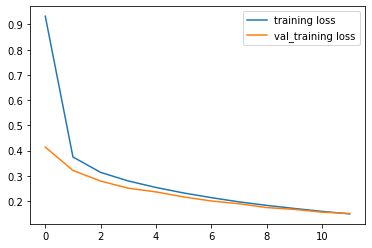

In [9]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='val_training loss')
plt.legend();

In [0]:
def plot_accuracy_and_loss(history, title):

    plt.figure(1, figsize=(15,10))

    # Accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    #plt.plot(history.history['val_categorical_accuracy'])
    plt.title(title+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='best')

    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
   # plt.plot(history.history['val_loss'])
    plt.title(title+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='best')

### Testing The Model

In [0]:
#!pip install pillow==4.00

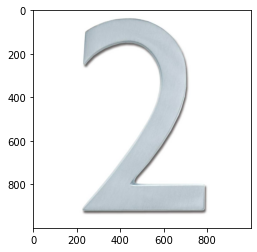

In [72]:
from PIL import Image
import cv2

img = cv2.imread('number2.jpg')
plt.imshow(img);

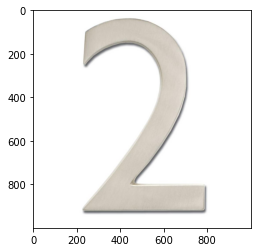

In [73]:
# The above image does not show the RGB but BGR format so convert into original color
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

### Preprocessing

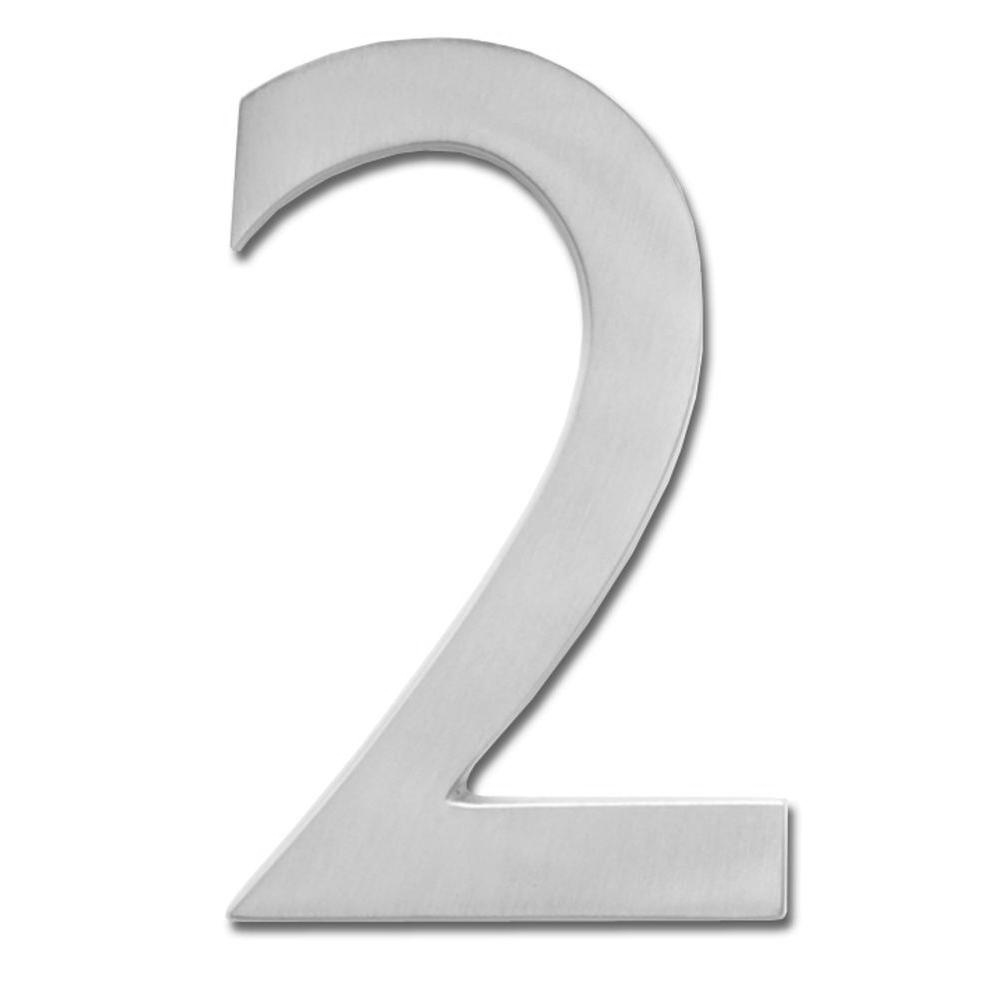

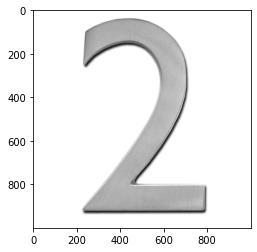

In [75]:
# We need to convert into gray scale
# Bunun icin tekrar okumamiz lazim cunku RGB'edn Gray e donusturemiyoruz but BGR to Gray available
from google.colab.patches import cv2_imshow
%matplotlib inline
img = cv2.imread('number2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Original image
cv2_imshow(gray)
# showing smaller
plt.imshow(gray, cmap='gray');

In [76]:
gray.shape

(1000, 1000)

New Shape is: (1000, 1000)


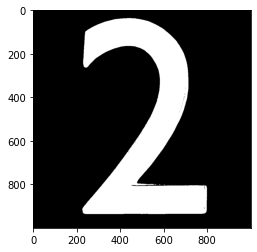

In [109]:
### Hala istedigimiz gibi degil, Threshold kullanarak belli bir degerin altini blak sonra white yapacahiz

(thresh, blackAndWhiteImage) = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
plt.imshow(blackAndWhiteImage, cmap='gray');
print ('New Shape is:', blackAndWhiteImage.shape);
# Evet bu istedigimiz format

In [78]:
# Saving image
cv2.imwrite('black2.jpg', blackAndWhiteImage)

True

In [104]:
!pip install pillow==4.1.1
!pip install --user opencv-contrib-python
%reload_ext autoreload
%autoreload

# COK ONEMLI: 
cv2.imread otomatik olarak 3 color channel olarak okur, gray scale olsa bile, flag'e dikkat et gray scale okurken

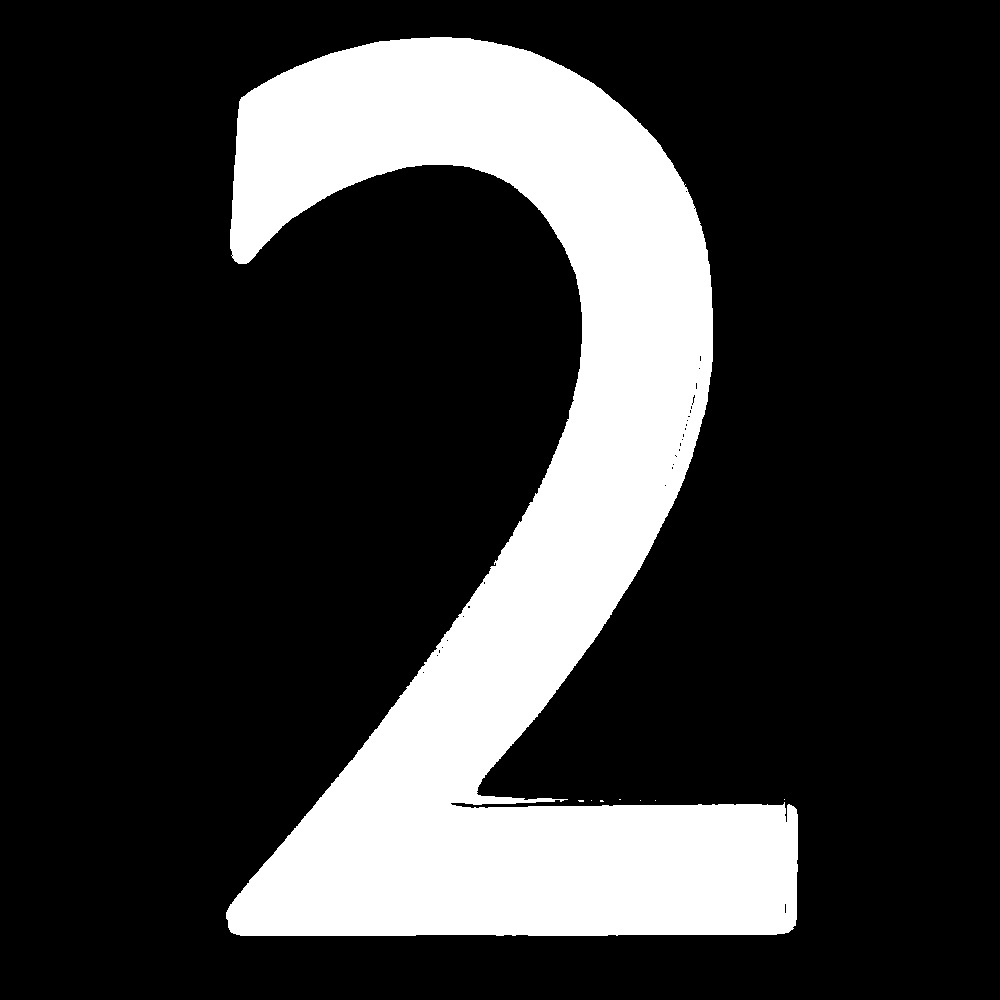

image shape (1000, 1000)


In [119]:
from PIL import Image
img = cv2.imread('black2.jpg', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)
#plt.imshow(img);
print('image shape', img.shape);

(28, 28, 1)


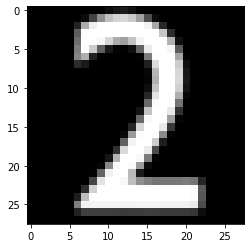

In [120]:
# We need to tranform image what we appiled above, resizing etc
from PIL import Image
PIL_image = Image.fromarray(img)
img = transform(PIL_image)
plt.imshow(image_convert(img));

In [115]:
img.shape

torch.Size([1, 28, 28])

In [127]:
img =img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, dim=1)
print(pred.item())
# 3 olarak predict etti HATA

3


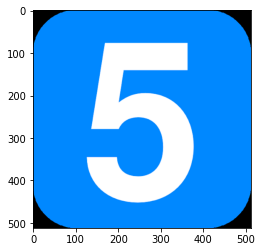

In [132]:
img = cv2.imread('number5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

shape: (512, 512)


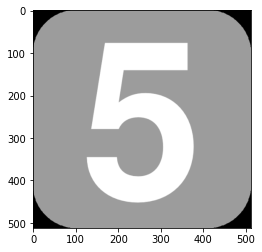

In [139]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
print('shape:', gray.shape);

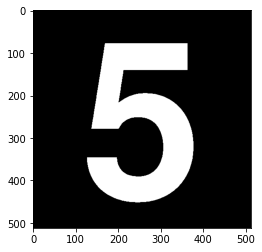

In [141]:
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage, cmap='gray');
# This is what we want

(28, 28, 1)


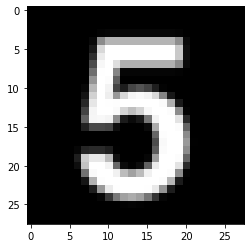

In [143]:
PIL_image = Image.fromarray(blackAndWhiteImage)
img = transform(PIL_image)
plt.imshow(image_convert(img));

In [164]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, dim=1)
print(pred.item())
# This time correct

5


### Batch Prediction From Validation Set

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


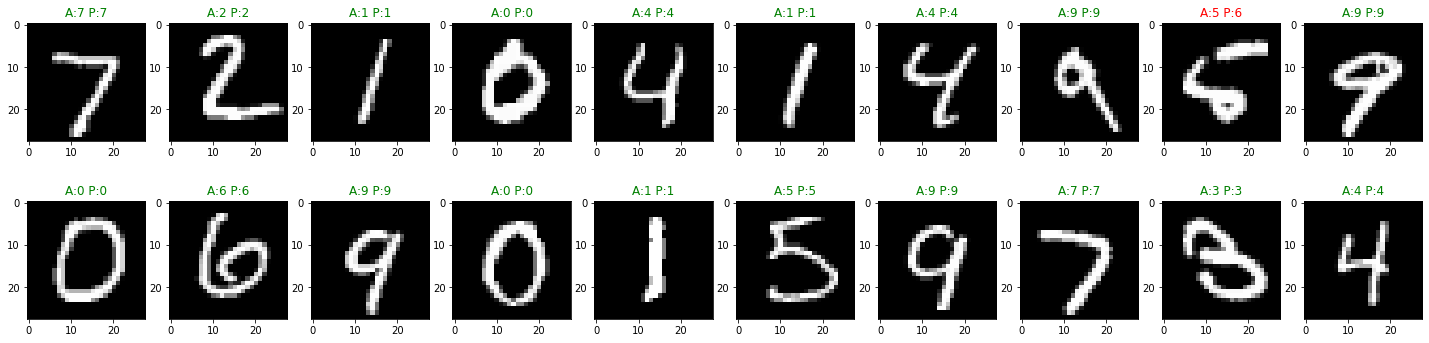

In [167]:
data_iter = iter(validation_loader);

# data_iter.next() --> bring us a BATCH of data each time
images, labels = data_iter.next();
images_ = images.view(images.shape[0], -1)# Flatteing the image except color channel
outputs = model(images_)
_, preds = torch.max(outputs, dim=1) 

fig = plt.figure(figsize=(25, 6));

# We ll check 20 images from training set
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1);
    plt.imshow(image_convert(images[idx]));
    # A: Actula P:Predicted
    ax.set_title("A:{} P:{}".format(str(labels[idx].item()), str(preds[idx].item())), color=('green' if preds[idx]==labels[idx] else 'red'));
plt.show();

In [168]:
print('Bismillahirrahmanirrahim')

Bismillahirrahmanirrahim
